## LSTM-VAE multi-modal anomaly detector

An unsupervised model for detecting anomaly whenever a deviation in reconstruction error is found in comparison to normal behavior. LSTM-VAE does multimodal data fusion by combining sensor feature data over time. A learnable threshold is used to decide on anomalous behavior. In the case of MHHD the sensors are Apps, Key Strokes, URLs, (and potentially Voice, Camera, Registry Keys).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import json
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers import LSTM, RepeatVector
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.datasets import mnist

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler 
from keras.callbacks import EarlyStopping

from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
nab_path = './data/NAB'
nab_data_path = nab_path + '/data/'

labels_filename = '/labels/combined_labels.json'
train_file_name = 'artificialNoAnomaly/art_daily_no_noise.csv' 
test_file_name = 'artificialWithAnomaly/art_daily_jumpsup.csv'

#train_file_name = 'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'
#test_file_name = 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

labels_file = open(nab_path + labels_filename, 'r')
labels = json.loads(labels_file.read())
labels_file.close()

def load_data_frame_with_labels(file_name):
    data_frame = pd.read_csv(nab_data_path + file_name)
    data_frame['anomaly_label'] = data_frame['timestamp'].isin(
        labels[file_name]).astype(int)
    return data_frame

train_data_frame = load_data_frame_with_labels(train_file_name)
test_data_frame = load_data_frame_with_labels(test_file_name)

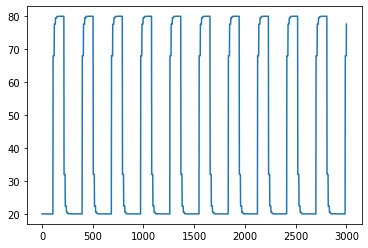

In [3]:
plt.plot(train_data_frame.loc[0:3000,'value'])

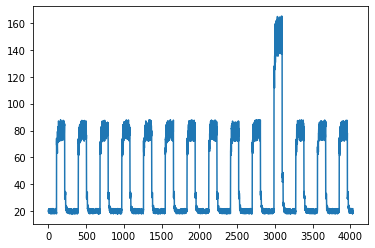

In [4]:
plt.plot(test_data_frame['value'])

In [5]:
train_data_frame_final = train_data_frame.loc[0:3000,:]
test_data_frame_final = test_data_frame

In [6]:
data_scaler = StandardScaler()
data_scaler.fit(train_data_frame_final[['value']].values)
train_data = data_scaler.transform(train_data_frame_final[['value']].values)
test_data = data_scaler.transform(test_data_frame_final[['value']].values)      

In [7]:
DATA_PATH = './data/'

def step_decay(epoch):
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 16.0
    lr_new = lr_init * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr_new

class LR_hist(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

In [8]:
def create_dataset(dataset, look_back=64):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back),:])
        dataY.append(dataset[i+look_back,:])

    return np.array(dataX), np.array(dataY)

In [9]:
X_data, y_data = create_dataset(train_data, look_back=64) #look_back = window_size
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
X_test, y_test = create_dataset(test_data, look_back=64)  #look_back = window_size

In [10]:
#training params
batch_size = 256
num_epochs = 64

#model params
timesteps = X_train.shape[1]
input_dim = X_train.shape[-1]
intermediate_dim = 16 #256
latent_dim = 2
epsilon_std = 1.0

In [11]:
#sampling layer
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [12]:
#likelihood layer
def likelihood(args):
    x, x_decoded_mean, x_decoded_scale = args
    dist = tf.contrib.distributions.MultivariateNormalDiag(x_decoded_mean, x_decoded_scale)
    likelihood = dist.log_prob(x)  
    return likelihood

In [13]:
#VAE architecture

#encoder
x = Input(shape=(timesteps, input_dim,), name="input_sequence")
h = LSTM(intermediate_dim)(x)

z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim, activation='softplus')(h)

#sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

#decoder
decoder_h = LSTM(intermediate_dim, return_sequences=True)
decoder_loc = LSTM(input_dim, return_sequences=True)
decoder_scale = LSTM(input_dim, activation='softplus', return_sequences=True)

h_decoded = RepeatVector(timesteps)(z)
h_decoded = decoder_h(h_decoded)

x_decoded_mean = decoder_loc(h_decoded)
x_decoded_scale = decoder_scale(h_decoded)

like = Lambda(likelihood, output_shape=(input_dim,), name="likelihood")([x, x_decoded_mean, x_decoded_scale])





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability).

In [14]:
#custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
    
    def vae_loss(self, x, z_mean, z_log_sigma, likelihood):        
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = -K.mean(likelihood - kl_loss)
        return loss

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_sigma = inputs[2]
        likelihood = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_sigma, likelihood)
        self.add_loss(loss, inputs=inputs)
        return x

In [15]:
y = CustomVariationalLayer()([x, z_mean, z_log_sigma, like])
vae_like = Model(x, like)
vae = Model(x, y)

In [16]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vae.compile(loss=None, optimizer=adam, metrics=['accuracy'])
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sequence (InputLayer)     (None, 64, 1)        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 16)           1152        input_sequence[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            34          lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            34          lstm_1[0][0]                     
__________________________________________________________________________________________________
lambda_1 

In [17]:
#define callbacks
file_name = DATA_PATH + 'lstm-vae-anomaly-detector.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
hist_lr = LR_hist()
reduce_lr = LearningRateScheduler(step_decay) 
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=64, verbose=1)
callbacks_list = [checkpoint, hist_lr, reduce_lr, early_stopping]

In [18]:
print("training vae model...")
hist = vae.fit(x=X_train, y=None, shuffle=True, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(X_val, None), verbose=2)

training vae model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2642 samples, validate on 294 samples
Epoch 1/64





 - 6s - loss: 1.9363 - val_loss: 1.8093

Epoch 00001: loss improved from inf to 1.93629, saving model to ./data/lstm-vae-anomaly-detector.hdf5
Epoch 2/64
 - 1s - loss: 1.7777 - val_loss: 1.7263

Epoch 00002: loss improved from 1.93629 to 1.77773, saving model to ./data/lstm-vae-anomaly-detector.hdf5
Epoch 3/64
 - 1s - loss: 1.6960 - val_loss: 1.6470

Epoch 00003: loss improved from 1.77773 to 1.69605, saving model to ./data/lstm-vae-anomaly-detector.hdf5
Epoch 4/64
 - 1s - loss: 1.6293 - val_loss: 1.5702

Epoch 00004: loss improved from 1.69605 to 1.62926, saving model to ./data/lstm-vae-anomaly-detector.hdf5
Epoch 5/64
 - 1s - loss: 1.5693 - val_loss: 1.5238

Epoch 00005: loss improved from 1.62926 to 1.56931, saving model to ./data/lstm-vae-anomaly-detector.hdf5
Epoch 6/64
 - 1s - loss: 1.5246 - val_loss:


Epoch 00044: loss did not improve from 1.44587
Epoch 45/64
 - 2s - loss: 1.4461 - val_loss: 1.4317

Epoch 00045: loss did not improve from 1.44587
Epoch 46/64
 - 2s - loss: 1.4455 - val_loss: 1.4358

Epoch 00046: loss improved from 1.44587 to 1.44545, saving model to ./data/lstm-vae-anomaly-detector.hdf5
Epoch 47/64
 - 2s - loss: 1.4449 - val_loss: 1.4345

Epoch 00047: loss improved from 1.44545 to 1.44493, saving model to ./data/lstm-vae-anomaly-detector.hdf5
Epoch 48/64
 - 2s - loss: 1.4453 - val_loss: 1.4362

Epoch 00048: loss did not improve from 1.44493
Epoch 49/64
 - 2s - loss: 1.4445 - val_loss: 1.4340

Epoch 00049: loss improved from 1.44493 to 1.44455, saving model to ./data/lstm-vae-anomaly-detector.hdf5
Epoch 50/64
 - 2s - loss: 1.4460 - val_loss: 1.4338

Epoch 00050: loss did not improve from 1.44455
Epoch 51/64
 - 2s - loss: 1.4453 - val_loss: 1.4317

Epoch 00051: loss did not improve from 1.44455
Epoch 52/64
 - 2s - loss: 1.4443 - val_loss: 1.4338

Epoch 00052: loss impr

In [ ]:
#vae.save(DATA_PATH + 'lstm-vae-anomaly-detector-final-model.h5', overwrite=True)
#vae.save_weights(DATA_PATH + 'lstm-vae-anomaly-detector-weights.h5', overwrite=True)

In [ ]:
#load saved model
#vae = load_model(DATA_PATH + 'final_model.h5')

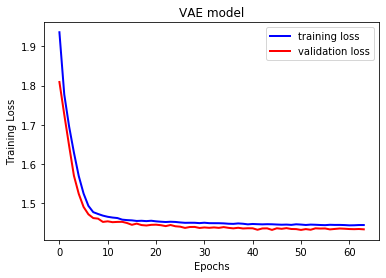

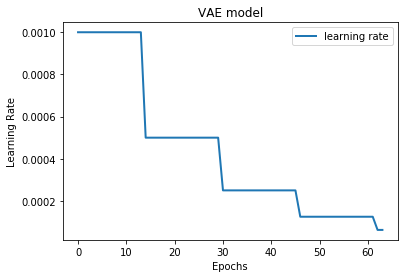

In [19]:
#generate plots

plt.figure()
plt.plot(hist.history['loss'], lw=2.0, c='b', label='training loss')
plt.plot(hist.history['val_loss'], lw=2.0, c='r', label='validation loss')
plt.title('VAE model')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig('./figures/lstm_vae_training_loss.png')


plt.figure()
plt.plot(hist_lr.lr, lw=2.0, label='learning rate')
plt.title('VAE model')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.savefig('./figures/lstm_vae_learning_rate.png')

In [20]:
pred_test = vae_like.predict(X_test)

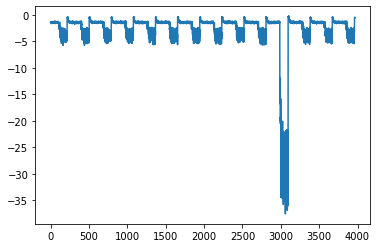

In [21]:
plt.plot(pred_test[:,0])

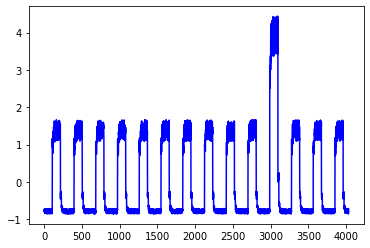

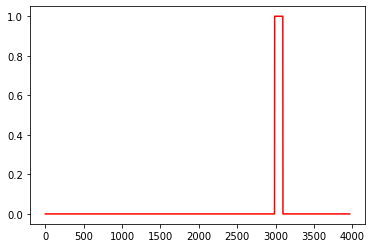

In [22]:
is_anomaly = pred_test[:,0] < -1e1
plt.figure()
plt.plot(test_data, color='b')
plt.figure()
plt.plot(is_anomaly, color='r')

## Keras to TensorFlow .pb file

In [23]:
#https://stackoverflow.com/questions/45466020/how-to-export-keras-h5-to-tensorflow-pb
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [24]:
from keras import backend as K
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in vae_like.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 69 variables.
INFO:tensorflow:Converted 69 variables to const ops.


In [25]:
tf.train.write_graph(frozen_graph, "./data", "lstm-vae-anomaly-detector.pb", as_text=False)

'./data\\lstm-vae-anomaly-detector.pb'

## Load the model and use it in TensorFlow

In [26]:
tf.reset_default_graph()
output_tf_model = 'lstm-vae-anomaly-detector.pb'
graph = tf.Graph()
with tf.gfile.GFile('./data/' + output_tf_model, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [27]:
with graph.as_default():
    # Define input tensor
    input_tensor = tf.placeholder(np.float32, shape = [None, timesteps, input_dim])
    tf.import_graph_def(graph_def, {'input_sequence': input_tensor})
graph.finalize()

In [35]:
vae_like.layers[-1].output

<tf.Tensor 'likelihood/MultivariateNormalDiag/log_prob/add:0' shape=(?, 64) dtype=float32>

In [43]:
sess = tf.Session(graph=graph)
output_tensor = graph.get_tensor_by_name("import/likelihood/MultivariateNormalDiag/log_prob/add:0")
pred_loaded_model = sess.run(output_tensor, feed_dict={input_tensor: X_test})

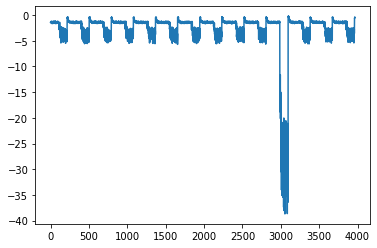

In [44]:
plt.plot(pred_loaded_model[:,0])

## References

[1] Park et al., "A Multimodal Anomaly Detector for Robot-Assisted Feeding Using an LSTM-Based Variational Autoencoder", arXiv 2018: https://arxiv.org/pdf/1711.00614.pdf  
[2] Zhang et al, "Time Series Anomaly Detection with Variational Autoencoders": https://arxiv.org/pdf/1907.01702.pdf  
[3] An et al, "Variational Autoencoder based Anomaly Detection using Reconstruction Probability": http://dm.snu.ac.kr/static/docs/TR/SNUDM-TR-2015-03.pdf  |